In [40]:
# import necessary libraries

# PyTorch based
import torch as pt
from torch import nn
import torchvision as tv
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor # converts pil imag3e or np array to FloatTensor of shape (C x H x W)
import torchmetrics as tm

# Matplotlib for visualization
import matplotlib.pyplot as plt

print(pt.__version__)
print(tv.__version__)


import importLib
importLib.import_from_github("https://raw.githubusercontent.com/GGisMee/PyTorch/main/ml_toolkit/helper_functions.py")
importLib.import_from_github("https://raw.githubusercontent.com/GGisMee/PyTorch/main/ml_toolkit/ml_funcs.py")

device = "cuda" if pt.cuda.is_available() else "cpu"
device


2.0.1+cu118
0.15.2+cu118
c:\Users\22gusgam\Desktop\k\PyTorch\03/helper_functions.py already exists
c:\Users\22gusgam\Desktop\k\PyTorch\03/ml_funcs.py already exists


'cpu'

### 1. Getting a dataset

The dataset we will be using is FashionMNIST from torchvision.datasets, (a dataset of gray scale images of clothing): https://pytorch.org/vision/main/datasets.html

In [41]:
# Setup training data
import os
print(os.getcwd())
train_data = datasets.FashionMNIST(
    root=f"{os.getcwd()}/data", # where should the file be placed
    train=True, # do we want to get the training dataset
    download=True, # do we want to download the dataset
    transform=ToTensor(), # how do we want to transform the data, 
    target_transform=None # how do we want to transform the labels/targets
    )

test_data = datasets.FashionMNIST(
    root=f"{os.getcwd()}/data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
    )

c:\Users\22gusgam\Desktop\k\PyTorch\03


In [42]:
print(len(train_data),len(test_data))

60000 10000


### Visualizing our dataset

#### As numbers

In [43]:
train_data.data.shape # batch size of 60000

torch.Size([60000, 28, 28])

In [44]:
# See the first training example
image, label = train_data[0]
class_names = train_data.classes
class_names[label]

'Ankle boot'

In [45]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [46]:
# Check the shape of our image
print(f"image shape{image.shape} -> [Color channels, height, width]")
print(f"image_label: {class_names[label]}")

image shapetorch.Size([1, 28, 28]) -> [Color channels, height, width]
image_label: Ankle boot


#### As pictures

image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot, 9')

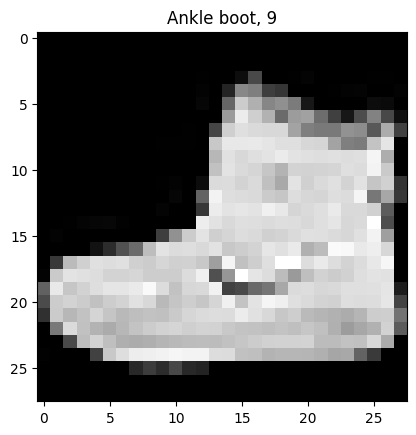

In [47]:
image, label = train_data[0]
print(f"image shape: {image.shape}")
plt.imshow(image.squeeze(),cmap=plt.cm.gray)
plt.title(f"{class_names[label]}, {label}")

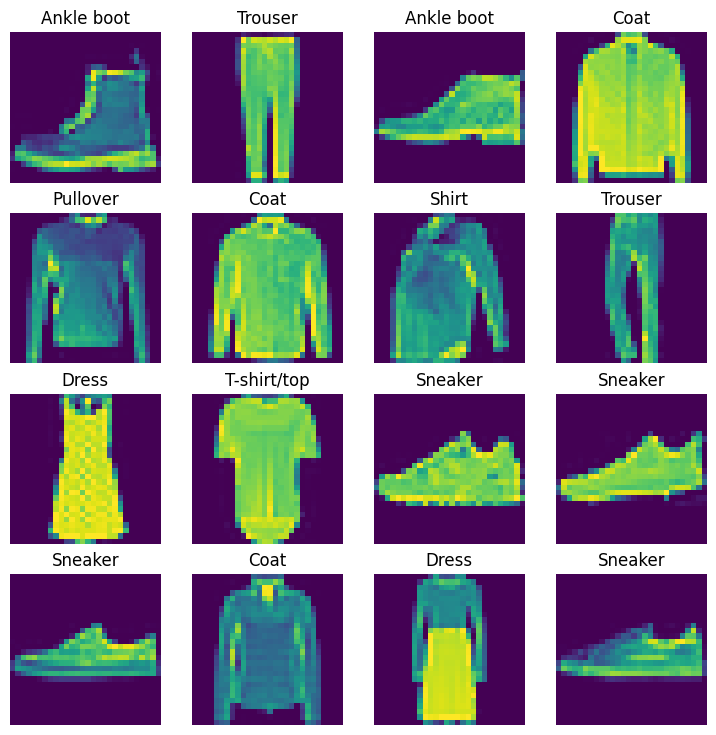

In [48]:
# Plot more images

#pt.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = pt.randint(0, len(train_data), size=[1]).item()
    #print(random_idx,i)
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze()) #, cmap="gray"
    plt.title(class_names[label])
    plt.axis(False)

Is non linearity necessary or not?

### Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets

DataLoaders turn our dataset into a Python iterable
more specifically, we want to turn our data into batches i.e mini-batches

Why do this?
1. It is more computationally efficient, as your computer may not be able to store 60000 images at the same time, therefore we brake it down to ex 32 images at a time (batch size)
2. it gives our nn more chances to update its gradient per epoch (update for each 32 images)

In [49]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into a generator like BataLoader that generates batches
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True) # shuffle = True gör att alla värden i arrayen blandas
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)





In [50]:
# Let's check out the dataloader
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001A2F7BDA710>, <torch.utils.data.dataloader.DataLoader object at 0x000001A2F7A15990>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [51]:
# Check out what's inside the training dataloader
train_features_batch, training_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, training_labels_batch.shape
# [32 batches, 1 color channel, 28 by, 28 pixels], 32 labels associated with the train_data

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

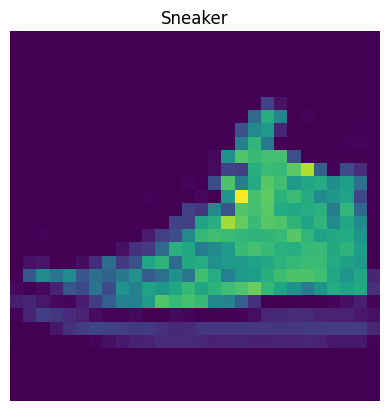

In [52]:
# Show a sample
pt.manual_seed(42)
random_idx = pt.randint(0, len(train_features_batch), size = [1]).item()
img, label = train_features_batch[random_idx], training_labels_batch[random_idx]
plt.imshow(img.squeeze())
plt.title(class_names[label.item()])
plt.axis(False)


### Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNets

CNN's are known for their capabilities to find patterns in visual data

Typical architecture of CNN:
Inputs -> ToTensor -> (CNN & ReLU & Pooling) layers -> output

Great visualization and understanding tool:
https://poloclub.github.io/cnn-explainer/

**Note**
> Explaination for different CNN Hyperparameters, Bättre visuel förklaring på länken ovan, eller: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

> Padding: På bilden läggs ett yttre tomt pixel lager på, vilket gör att output shapen blir från ex 4,4 till 5,5

> Kernal Size: Storleken på den större rutan som går ihop till den mindre

> Stride: gör att vissa pixlar i ett rutnät hoppas över i komprissionen

In [53]:
# Create a convolutional neural network
class FashoinMNISTModelV2(nn.Module):
    """Module architecture that replicates the TinyVGG model from CNN explainer"""

    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.hidden_units = hidden_units
        self.conv_block_1 = nn.Sequential(
            # 2d för 2 dimensioner x,y
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, 
                      kernel_size=3, stride=1, padding=1), # Refered to as Hyperparameters, bc we can change them ourselves
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, 
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # tar basically flera pixlar i en plupp och tar den med störst värde därav max
            # antalet pixlar minskar därför, i slutet är alla lager är antalet pixlar kanske en 6 eller ännu mindre del av storleken på originalet 
            nn.MaxPool2d(kernel_size=2), 
        )
        self.conv_block_2 = nn.Sequential(
            # 2d för 2 dimensioner x,y
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, 
                      kernel_size=3, stride=1, padding=1), # Refered to as Hyperparameters, bc we can change them ourselves
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, 
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # tar basically flera pixlar i en plupp och tar den med störst värde därav max
            # antalet pixlar minskar därför, i slutet är alla lager är antalet pixlar kanske en 6 eller ännu mindre del av storleken på originalet 
            nn.MaxPool2d(kernel_size=2), 
        )
        self.classifier = nn.Sequential( 
            nn.Flatten(), # Denna krävs eftersom outputen är 2 dimensionel och shapen är [a,b,...?] och inte [a]
            nn.Linear(hidden_units*49, output_shape) # eftersom shapen minskar hela tiden är det svårt att veta vad hidden_units är, men det finns ett trick
        )

    def forward(self, x:pt.Tensor) -> pt.Tensor:
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(f"Multiply by: {int(pt.tensor(x.shape).prod().item()/self.hidden_units)}")
        x = self.classifier(x)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [54]:
# Instanciate our first model 
print(f"Denna har 2 st channels med width och height:{image.shape}")
# annars kan den ha 3 st med color channel
pt.manual_seed(42)
model_2 = FashoinMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
#print(model_2)

Denna har 2 st channels med width och height:torch.Size([1, 28, 28])


### Examplification of CNN layers

#### Stepping through nn.Conv2d()

In [55]:
pt.manual_seed(42)

# Create a batch of images
images = pt.rand(size=(32, 3, 64,64))
test_image = images[0]
print(f"Image batch shape: {images.shape}")
print(f"Single Image shape: {test_image.shape}")
#print(f"Test Image: {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single Image shape: torch.Size([3, 64, 64])


In [56]:
pt.manual_seed(42)
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)

# Pass the data through the cocnvolutional layer
conv_output = conv_layer(test_image)
print(f"{test_image.shape} -> {conv_output.shape}")


torch.Size([3, 64, 64]) -> torch.Size([10, 62, 62])


#### Steping through nn.MaxPool2d():

In [57]:
kernal_size_v = 3
# Print out original image shape
print(f"Before MaxPool2d: {test_image.shape}")

max_pool_layer = nn.MaxPool2d(kernel_size=kernal_size_v)

print(f"After: {max_pool_layer(test_image).shape}")
print()
print(f"The amount of x,y pixels are devided by the kernal_size as they are compressed: {64//kernal_size_v}")

Before MaxPool2d: torch.Size([3, 64, 64])
After: torch.Size([3, 21, 21])

The amount of x,y pixels are devided by the kernal_size as they are compressed: 21


In [58]:
random_tensor = pt.rand(size=(1,2,2))
print(f"Original: {random_tensor}")
max_pool_layer_2 = nn.MaxPool2d(kernel_size=2)
resulting_tensor = max_pool_layer_2(random_tensor)
print(f"Resulting: {resulting_tensor}")

Original: tensor([[[0.3865, 0.2003],
         [0.4563, 0.2539]]])
Resulting: tensor([[[0.4563]]])


### Testing model

In [59]:
import torch as pt


dummy_batch = pt.rand(size=(1,28, 28))
model_2(dummy_batch.unsqueeze(0))


tensor([[ 0.0338, -0.0729,  0.0573, -0.0421, -0.0076,  0.0201,  0.0026, -0.0134,
          0.0221,  0.0005]], grad_fn=<AddmmBackward0>)

### Setup loss and optimizer functions

In [60]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

Optimizer = pt.optim.SGD(params=model_2.parameters(), lr=0.1)

### Training and testing model_2 using trian and test functions

In [61]:
from helper_functions import print_train_time
from ml_funcs import Model_operations
from timeit import default_timer as timer
start = timer()
from tqdm.auto import tqdm
pt.manual_seed(42)
pt.cuda.manual_seed(42)

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    print("----------")
    (Model_operations.train_step(model_2, train_dataloader, Optimizer, loss_fn, accuracy_fn, device,True))
    (Model_operations.test_step(model_2, test_dataloader, loss_fn, accuracy_fn,device,True))

print_train_time(start,timer(), device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
train loss: 0.5914061665534973, train accuracy: 78.505
Test loss: 0.3914, Test acc: 85.8926
Epoch: 1
----------
train loss: 0.36051449179649353, train accuracy: 87.16333333333333
Test loss: 0.3492, Test acc: 87.1106
Epoch: 2
----------
train loss: 0.3226599395275116, train accuracy: 88.23333333333333
Test loss: 0.3206, Test acc: 88.4784

Train time on cpu: 143.998 seconds


143.99839309998788

In [66]:
model_2_results = Model_operations.eval_model(model_2, test_dataloader, loss_fn, accuracy_fn, device)
print(list(model_2_results.values())[1:])

[0.3205651640892029, 88.47843450479233]
